In [1]:
%load_ext autoreload
%autoreload 2


from src.chem_draw import make_svg_drawer_non_scaling, mol_to_svg
from rdkit import Chem
from IPython.display import SVG

In [2]:
drawer = make_svg_drawer_non_scaling(width=300, height=200)

name_smi = {
    'methyl_dimethyl_ha': 'OC(C)C(C)(C)C(=O)O',
    'dipropyl_ha': 'OCC(CCC)(CCC)C(=O)O',
    'c4_methyl_diol': 'CC(O)C(C)(O)C',
    'hopa': 'O=C(O)C(=O)CCCO',
    'mvl_acid_precursor': 'C=C(CCCO)C(=O)O',
    'mvl': 'C=C1CCCOC1=O',
    '2_methylene_glutarate': 'C=C(CCC(=O)O)C(=O)O',
    '4_methylene_glutamate': 'C=C(CC(N)C(=O)O)C(=O)O',
    'xylose': 'O=CC(O)C(O)C(O)CO',
    'homocitrate': 'C(CC(CC(=O)O)(C(=O)O)O)C(=O)O',
    'hydroxypivalic_acid': 'OCC(C)(C)C(=O)O',

}

mols = [Chem.MolFromSmiles(smi) for smi in name_smi.values()]

for name, smi in name_smi.items():
    mol = Chem.MolFromSmiles(smi)
    txt = mol_to_svg(mol, drawer)

    with open(f"../artifacts/illustrative_imgs/{name}.svg", 'w') as f:
        f.write(txt)

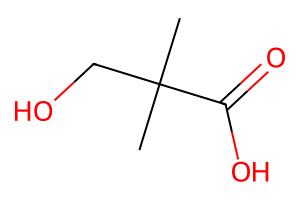

In [3]:
display(SVG(txt))

In [ ]:
sheets = []
sheetnames = []

for st_pair, paths in to_vis.items():
    print(st_pair)
    # Set up sheets headers & pwy svg outdir
    print("Generating svgs & csv")
    headers = ['id', 'starter', 'target', 'mdf', 'pwy_ave_mcs'] + [f"mcs_rxn_{g+1}" for g in range(generations)] + [f"uniprot_rxn_{g+1}" for g in range(generations)]
    pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(pwy_svg_outdir)

    rows_for_sheet = []
    for path in paths:
        row = [] # One path
        up_strings = thresholded_uniprot_strings(pe.get_path_enzymes(path), enzyme_validation_threshold)
        prc_mcs = pe.get_path_prc_mcs(path) # Top-analogue prc_mcs for each predicted reaction in path 
        row += [path.id, path.starter, path.target, path.mdf, sum(prc_mcs) / len(prc_mcs)] # Append average prc_mcs

        # Append reaction prc_mcs
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(prc_mcs[g])
            else:
                row.append(None)

        # Append uniprot strings
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(up_strings[g])
            else:
                row.append(None)

        # Draw pathway svg 
        sma_hash_pairs = []
        for prid in path.reaction_ids:
            pr = pe.predicted_reactions[prid]
            analogue = pr.top_analogue()['analogue']
            sma_hash_pairs.append([(pr.smarts, prid), (analogue.smarts, analogue.id)])
        
        outpath = pwy_svg_outdir + f"{path.id:04}.svg"
        draw_pwy_svg(sma_hash_pairs, path.id, outpath)

        rows_for_sheet.append(row)

    # Make df for this st pair
    sheets.append(pd.DataFrame(rows_for_sheet, columns=headers).set_index('id'))
    sheetnames.append("_".join(st_pair))

    # Convert svgs to pdfs
    print("Generating pdfs")
    tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(tmp_pdf_outdir)
    for path in paths:
        cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{path.id:04}.pdf", f"{pwy_svg_outdir}{path.id:04}.svg"]
        subprocess.run(cmd)

    # Concatenate pdfs
    print("Concatenating pdfs")
    pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-4]}/"
    ensure_dirs(pwy_pdf_outdir)
    cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
    individual_pwys = [f"{tmp_pdf_outdir}{path.id:04}.pdf" for path in paths]

    cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
    subprocess.run(cmd)

# Concatenate sheets into xls
print("Saving xlsx")
writer = pd.ExcelWriter(f"../artifacts/pwy_xls/{fn[:-4]}" + '.xlsx') # Arbitrary output name
for i, df in enumerate(sheets):
    df.to_excel(writer, sheet_name=sheetnames[i])
writer.save()

# Remove stuff
dirs = ['../artifacts/' + elt for elt in ['tmp_pdfs', 'rxn_svgs', 'pwy_svgs', 'mol_svgs']]
for elt in dirs:
    subprocess.run([f"rm -r {elt}/*"], shell=True)